## Community dFBA 

Community dFBA extends traditional dFBA by allowing multiple interacting agents or organisms to compete or collaborate for limited resources within a shared environment. This approach allows for a more comprehensive understanding of metabolic interactions and resource allocation in complex microbial communities.

In the following example we implement a community dFBA model in which two different mutant strains of *E. coli*, one incapable of respiring due to a mutation in the terminal oxidase, and the other incapable of fermenting due to a mutation in the glucose transporter, help each other grow.


In [1]:
import numpy as np
from tqdm import tqdm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

%matplotlib inline

Create or load a cobrapy model. Here, we use the 'textbook' e-coli core model.

In [2]:
import cobra
from cobra.io import load_model
model1 = load_model('textbook')
model2 = load_model('textbook')

Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-06


In [3]:
# model1.reactions

In [4]:
print(model1.reactions.EX_glc__D_e.bounds)
print(model1.reactions.EX_for_e.bounds)
print(model1.reactions.EX_ac_e.bounds)
print(model1.reactions.EX_etoh_e.bounds)
print(model1.reactions.EX_o2_e.bounds)

(-10.0, 1000.0)
(0.0, 1000.0)
(0.0, 1000.0)
(0.0, 1000.0)
(-1000.0, 1000.0)


In [5]:
sol1 = model1.optimize()
sol1.fluxes.get('EX_o2_e')

-21.79949265599875

We knock out the terminal oxidase in the $1^{st}$ model

In [6]:
model1.reactions.CYTBD.knock_out()
sol1 = model1.optimize()
print(f'Mutant E. coli with terminal oxidase knocked out: {sol1}')
sol1.fluxes.get('EX_o2_e')

Mutant E. coli with terminal oxidase knocked out: <Solution 0.212 at 0x135e1ef80>


0.0

We knock out the glucose transporter in the $2^{nd}$ model, but allow uptake of acetate, and ethanol.

In [7]:
model2.reactions.EX_glc__D_e.bounds = (-10.0,1000.)
model2.reactions.EX_for_e.bounds = (0., 1000.)
model2.reactions.EX_ac_e.bounds = (-10., 1000.)
model2.reactions.EX_etoh_e.bounds = (-10., 10.)
model2.reactions.EX_o2_e.bounds = (-1000., 1000.)

print(model2.reactions.EX_glc__D_e.bounds)
print(model2.reactions.EX_for_e.bounds)
print(model2.reactions.EX_ac_e.bounds)
print(model2.reactions.EX_etoh_e.bounds)
print(model2.reactions.EX_o2_e.bounds)

(-10.0, 1000.0)
(0.0, 1000.0)
(-10.0, 1000.0)
(-10.0, 10.0)
(-1000.0, 1000.0)


In [8]:
model2.reactions.GLCpts.knock_out()
sol2 = model2.optimize()
print(f'Mutant E. coli with glucose uptake knocked out: {sol2}')
sol2.fluxes.get('EX_o2_e')

Mutant E. coli with glucose uptake knocked out: <Solution 0.550 at 0x135e1fee0>


-25.976442530902162

## Generate a dynamic setup for each species in the community

In these setups, we define the dynamic bounds for each species in the community. If metabolites become negative they are set to zero.

### Dynamic setup for model 1 (E. coli without terminal oxidase, secreting acetate and ethanol)

In [9]:
def add_dynamic_bounds_1(model, y):

    """Use external concentrations to bound the uptake flux of glucose."""
    
    biomass, glucose, acetate, etoh, o2 = y  # expand the boundary species

    glucose = np.max([glucose, 0.0])
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import

    acetate = np.max([acetate, 0.0])
    acetate_max_import = -10 * acetate / (1 + acetate)
    acetate_max_export = 10 * acetate / (1 + acetate)
    model.reactions.EX_ac_e.lower_bound = acetate_max_import
    model.reactions.EX_ac_e.upper_bound = acetate_max_export

    # Ethanol diffuses freely
    etoh = np.max([etoh, 0.0])
    etoh_max_import = -10 * etoh
    etoh_max_export = 10 * etoh
    model.reactions.EX_etoh_e.lower_bound = etoh_max_import        
    model.reactions.EX_etoh_e.upper_bound = etoh_max_export
    
    # block O2 consumption
    model.reactions.EX_o2_e.lower_bound = 0.0
    model.reactions.EX_o2_e.upper_bound = 0.0    

    
def dynamic_system_1(t, y):

    """Calculate the time derivative of external species."""

    global feasibility_1, inner_sol_1

    biomass, glucose, acetate, etoh, o2 = y  # expand the boundary species
    n_fluxes = len(y)
    
    # Calculate the specific exchanges fluxes at the given external concentrations.    
    with model1 as model:
        add_dynamic_bounds_1(model, y)

        model.slim_optimize()

        if model.solver.status == 'optimal':
            inner_sol_1 = model.optimize()
            fluxes = inner_sol_1.fluxes.get(['Biomass_Ecoli_core', 'EX_glc__D_e', 'EX_ac_e', 'EX_etoh_e', 'EX_o2_e']).values
            fluxes *= biomass
            feasibility_1 = -1.0
        else:
            fluxes = np.zeros(n_fluxes)
            feasibility_1 = 0.0

    return fluxes


def infeasible_event_1(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function just passes the infeasible variable calculated by dynamic_system_1.

    """
    
    return feasibility_1
    
# Define later
# infeasible_event_1.direction = 1
# infeasible_event_1.terminal = True

### Dynamic setup for model 2 (E. coli without glucose transporter, importing acetate and ethanol)

In [10]:
def add_dynamic_bounds_2(model, y):

    """Use external concentrations to bound the uptake flux of acetate and ethanol."""

    biomass, glucose, acetate, etoh, o2 = y  # expand the boundary species
    
    # Block glucose uptake
    model.reactions.EX_glc__D_e.upper_bound = 0.0
    model.reactions.EX_glc__D_e.lower_bound = 0.0 

    acetate = np.max([0.0, acetate])
    acetate_max_import = -10. * acetate / (1 + acetate)
    acetate_max_export = 10. * acetate / (1 + acetate)
    model.reactions.EX_ac_e.lower_bound = acetate_max_import    
    model.reactions.EX_ac_e.upper_bound = acetate_max_export

    etoh = np.max([0.0, etoh])
    etoh_max_import = -10. * etoh / (1 + etoh)
    etoh_max_export = 10. * etoh / (1 + etoh)
    model.reactions.EX_etoh_e.lower_bound = etoh_max_import    
    model.reactions.EX_etoh_e.upper_bound = etoh_max_export

    # Terminal oxidase with high affinity for O2
    o2 = np.max([0.0, o2])
    o2_max_import = -20 * o2 / (0.01 + o2)
    model.reactions.EX_o2_e.lower_bound = o2_max_import
    model.reactions.EX_o2_e.upper_bound = 20 * o2    
    

def dynamic_system_2(t, y):
    
    """Calculate the time derivative of external species."""

    global feasibility_2, inner_sol_2

    biomass, glucose, acetate, etoh, o2 = y  # expand the boundary species
    n_fluxes = len(y)

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model2 as model:
        add_dynamic_bounds_2(model, y)

        model.slim_optimize()

        if model.solver.status == 'optimal':
            inner_sol_2 = model.optimize()
            fluxes = inner_sol_2.fluxes.get(['Biomass_Ecoli_core', 'EX_glc__D_e', 'EX_ac_e', 'EX_etoh_e', 'EX_o2_e']).values
            fluxes *= biomass
            feasibility_2 = -1.0
        else:
            fluxes = np.zeros(n_fluxes)
            feasibility_2 = 0.0

    return fluxes


def infeasible_event_2(t, y):
    """
    Determine solution feasibility.
    
    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function just passes the infeasible variable calculated by dynamic_system_2.

"""
    return feasibility_2

# Define later
# infeasible_event_2.direction = 1
# infeasible_event_2.terminal = True

We want to continue updating the state of the system even if one of the models encounters an infeasible solution.

This is achieved by setting the termination to `False` in the infeasible event function for the dynamic update of each model.

In [11]:
# Model1    
infeasible_event_1.direction = 1
infeasible_event_1.terminal = False

# Model2
infeasible_event_2.direction = 1
infeasible_event_2.terminal = False


#### Initialize tensorboard

In [12]:
# from torch.utils.tensorboard import SummaryWriter
# tbwriter = SummaryWriter('logs/init_writer')

### A: Simulate a bioreactor with constant oxygen


In [13]:
# import warnings
# warnings.filterwarnings("ignore", module="optlang")
# warnings.filterwarnings("ignore", module="cobra")

In [14]:
# Prepare the initial conditions for the two models.
niter = 1500
delta_t = 0.01
n_compartments = 2
n_metabolites = 4

mass_global = np.zeros((n_compartments,niter+1))
metabolites_global = np.zeros((n_metabolites,niter+1))

# Here we store all the fluxes from each species at each time
sol1_global = []
sol2_global = []

# Feasibility
sol_feasibility_global = -np.ones((n_compartments,niter+1))

# Initial conditions
y0_1_mass = 0.1
y0_2_mass = 0.01
y0_glucose = 20
y0_acetate = 0.4 # minimal external concentration to support growth
y0_etoh = 0.4 # minimal external concentration to support growth
# y0_o2 = 0.273 # O2 concentration in an open system in equilibrium with air
y0_o2 = 1.0 # initial oxygen concentration

y0_1 = [y0_1_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2] # Initial conditions for biomass, glucose, acetate, etoh and o2
y0_2 = [y0_2_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2] # Initial conditions for biomass, glucose, acetate, etoh and o2
y0_metabolites = np.array([y0_glucose, y0_acetate, y0_etoh, y0_o2])

# Initialize global solutions with initial optimization
sol1_global.append(model1.optimize())
sol2_global.append(model2.optimize())

# Initialize global concentrations with initial conditions for each concentration calculated explicitly
mass_global[:, 0] = [y0_1_mass, y0_2_mass]
metabolites_global[:, 0] = [y0_glucose, y0_acetate, y0_etoh, y0_o2]

# Initialize tensorboard logs for time 0
# with tbwriter as writer:
#     writer.add_scalar('mass_model_1', y0_1_mass, 0)
#     writer.add_scalar('mass_model_2', y0_2_mass, 0)
#     writer.add_scalar('glucose', y0_glucose, 0)
#     writer.add_scalar('acetate', y0_acetate, 0)
#     writer.add_scalar('etoh', y0_etoh, 0)
#     writer.add_scalar('o2', y0_o2, 0)

t_global = [0]

for iter in tqdm(range(niter)):

    ts = np.linspace(0, delta_t, 2)  # Desired integration resolution and interval

    with model1 as model:

        sol1 = solve_ivp(
            fun=dynamic_system_1,
            events=[infeasible_event_1],
            t_span=(ts.min(), ts.max()),
            y0=y0_1,
            t_eval=ts,
            method='RK45'
        )
        # We append the last fluxes
        sol1_global.append(inner_sol_1)

    with model2 as model:

        sol2 = solve_ivp(
            fun=dynamic_system_2,
            events=[infeasible_event_2],
            t_span=(ts.min(), ts.max()),
            y0=y0_2,
            t_eval=ts,
            method='RK45'
        )
        # We append the last fluxes
        sol2_global.append(inner_sol_2)

    # Store the time points
    t_global.append(t_global[-1] + delta_t)            

    # Store feasibilities
    sol_feasibility_global[:, iter+1] = feasibility_1, feasibility_2

    # Update the masses
    y0_1_mass = sol1['y'][0, -1]
    y0_2_mass = sol2['y'][0, -1]

    # Update the shared metabolites concentrations subtracting the initial value
    # from the sum of both strains updates for production or consumption.
    d1_metabolites = sol1['y'][1:n_metabolites+1,-1]-sol1['y'][1:n_metabolites+1,0]
    d2_metabolites = sol2['y'][1:n_metabolites+1,-1]-sol2['y'][1:n_metabolites+1,0]
    y0_metabolites = y0_metabolites + d1_metabolites + d2_metabolites

    # Reset metabolites concentrations if expected to remain constant
    # y0_metabolites[0] = y0_glucose  
    # y0_metabolites[1] = y0_acetate  
    # y0_metabolites[2] = y0_etoh  
    y0_metabolites[3] = y0_o2  

    # Update the initial conditions for both strains
    y0_1 = [y0_1_mass] + list(y0_metabolites)
    y0_2 = [y0_2_mass] + list(y0_metabolites)

    # Store the results in the global solutions
    mass_global[:, iter+1] = [y0_1_mass, y0_2_mass]
    metabolites_global[:, iter+1] = y0_metabolites

    # Save logs for tensorboard
    # with tbwriter as writer:
    #     writer.add_scalar('mass_model_1', y0_1_mass, iter+1)
    #     writer.add_scalar('mass_model_2', y0_2_mass, iter+1)
    #     writer.add_scalar('glucose', y0_metabolites[0], iter+1)
    #     writer.add_scalar('acetate', y0_metabolites[1], iter+1)
    #     writer.add_scalar('etoh', y0_metabolites[2], iter+1)
    #     writer.add_scalar('o2', y0_metabolites[3], iter+1)

    # Stop the simulation if both solutions are infeasible
    # if feasibility_1 == 0 and feasibility_2 == 0:
    #     print(f"Both solutions are infeasible")
    #     break


100%|██████████| 1500/1500 [02:28<00:00, 10.08it/s]


#### Plot timelines of biomass, metabolites and feasibility

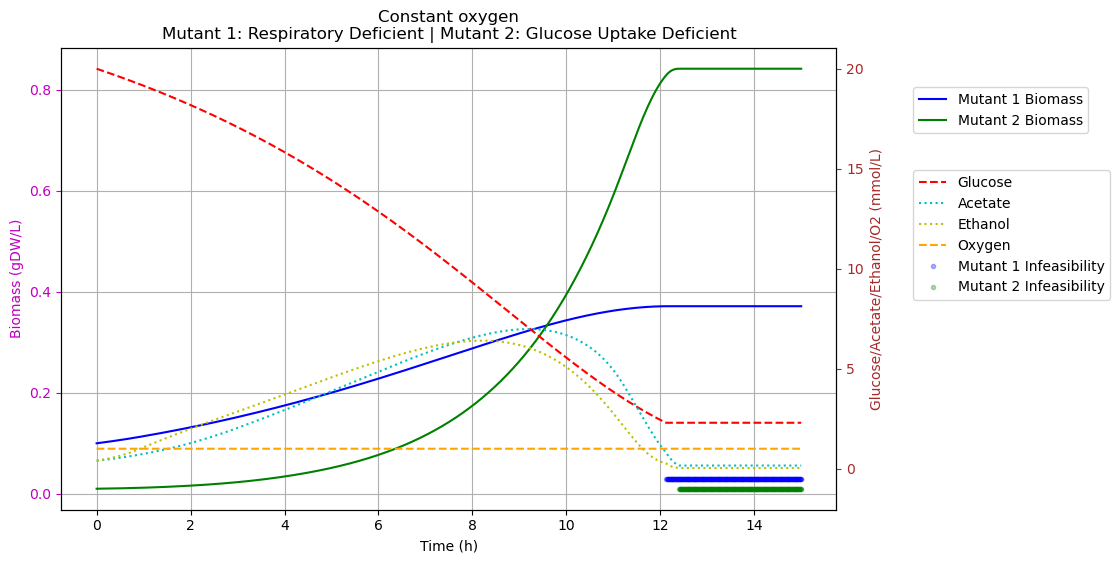

In [15]:
n_t = len(t_global)
t = np.array(t_global)

# select times where solutions are infeasible
infeasible_index_1 = sol_feasibility_global[0][:n_t] == 0
infeasible_index_2 = sol_feasibility_global[1][:n_t] == 0
t_inf_1 = t[infeasible_index_1]
t_inf_2 = t[infeasible_index_2]

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(t, mass_global[0][:n_t], label='Mutant 1 Biomass', color='b')
ax.plot(t, mass_global[1][:n_t], label='Mutant 2 Biomass', color='g')
ax.tick_params(axis='y', colors='m')
ax2 = plt.twinx(ax)
ax2.plot(t, metabolites_global[0][:n_t], color='r', label='Glucose', linestyle='--')
ax2.plot(t, metabolites_global[1][:n_t], color='c', label='Acetate', linestyle=':')
ax2.plot(t, metabolites_global[2][:n_t], color='y', label='Ethanol', linestyle=':')
ax2.plot(t, metabolites_global[3][:n_t], color='orange', label='Oxygen', linestyle='--')
ax2.tick_params(axis='y', colors='brown')

# plot on secondary y-axis the feasibility of both models
ax2.plot(t_inf_1, 0 * t_inf_1 - 0.5, 'bo', markersize=3, label=f'Mutant 1 Infeasibility', alpha=0.3)
ax2.plot(t_inf_2, 0 * t_inf_2 - 1.0, 'go', markersize=3, label=f'Mutant 2 Infeasibility', alpha=0.3)

ax.set_ylabel('Biomass (gDW/L)', color='m')
ax.set_xlabel('Time (h)', color='k')
ax2.set_ylabel('Glucose/Acetate/Ethanol/O2 (mmol/L)', color='brown')

ax.grid()

# Add a title in two lines. In the second line specifiy mutant 1 is respiratory deficient, and mutant 2 cannot uptake glucose
ax.title.set_text('Constant oxygen\nMutant 1: Respiratory Deficient | Mutant 2: Glucose Uptake Deficient')

# Place legends outside the figure frame on the top right
ax.legend(bbox_to_anchor=(1.09, 0.93), loc='upper left')
ax2.legend(bbox_to_anchor=(1.09, 0.75), loc='upper left')

plt.show()

### B. Simulate a bioreactor with constant glucose and oxygen

In [16]:
# Prepare the initial conditions for the two models.
niter = 6000
delta_t = 0.005
n_compartments = 2
n_metabolites = 4

mass_global = np.zeros((n_compartments,niter+1))
metabolites_global = np.zeros((n_metabolites,niter+1))

# Here we store all the fluxes from each species at each time
sol1_global = []
sol2_global = []

# Feasibility
sol_feasibility_global = -np.ones((n_compartments,niter+1))

# Initial conditions
y0_1_mass = 0.1
y0_2_mass = 0.01
y0_glucose = 20
y0_acetate = 0.4 # minimal external concentration to support growth
y0_etoh = 0.4 # minimal external concentration to support growth
y0_o2 = 1.0 # initial oxygen concentration

y0_1 = [y0_1_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2] # Initial conditions for biomass, glucose, acetate, etoh and o2
y0_2 = [y0_2_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2] # Initial conditions for biomass, glucose, acetate, etoh and o2
y0_metabolites = np.array([y0_glucose, y0_acetate, y0_etoh, y0_o2])

# Initialize global solutions with initial optimization
sol1_global.append(model1.optimize())
sol2_global.append(model2.optimize())

# Initialize global concentrations with initial conditions for each concentration calculated explicitly
mass_global[:, 0] = [y0_1_mass, y0_2_mass]
metabolites_global[:, 0] = [y0_glucose, y0_acetate, y0_etoh, y0_o2]

# Initialize tensorboard logs for time 0
# with tbwriter as writer:
#     writer.add_scalar('mass_model_1', y0_1_mass, 0)
#     writer.add_scalar('mass_model_2', y0_2_mass, 0)
#     writer.add_scalar('glucose', y0_glucose, 0)
#     writer.add_scalar('acetate', y0_acetate, 0)
#     writer.add_scalar('etoh', y0_etoh, 0)
#     writer.add_scalar('o2', y0_o2, 0)

t_global = [0]

for iter in tqdm(range(niter)):

    ts = np.linspace(0, delta_t, 2)  # Desired integration resolution and interval

    with model1 as model:

        sol1 = solve_ivp(
            fun=dynamic_system_1,
            events=[infeasible_event_1],
            t_span=(ts.min(), ts.max()),
            y0=y0_1,
            t_eval=ts,
            method='RK45'
        )
        # We append the last fluxes
        sol1_global.append(inner_sol_1)

    with model2 as model:

        sol2 = solve_ivp(
            fun=dynamic_system_2,
            events=[infeasible_event_2],
            t_span=(ts.min(), ts.max()),
            y0=y0_2,
            t_eval=ts,
            method='RK45'
        )
        # We append the last fluxes
        sol2_global.append(inner_sol_2)

    # Store the time points
    t_global.append(t_global[-1] + delta_t)            

    # Store the individual feasibilities
    sol_feasibility_global[:, iter+1] = feasibility_1, feasibility_2

    # Update the masses
    y0_1_mass = sol1['y'][0, -1]
    y0_2_mass = sol2['y'][0, -1]

    # Update the shared metabolites concentrations subtracting the initial value
    # from the sum of both strains updates for production or consumption.
    d1_metabolites = sol1['y'][1:n_metabolites+1,-1]-sol1['y'][1:n_metabolites+1,0]
    d2_metabolites = sol2['y'][1:n_metabolites+1,-1]-sol2['y'][1:n_metabolites+1,0]
    y0_metabolites = y0_metabolites + d1_metabolites + d2_metabolites

    # Reset metabolites concentrations if expected to remain constant
    y0_metabolites[0] = y0_glucose  
    # y0_metabolites[1] = y0_acetate  
    # y0_metabolites[2] = y0_etoh  
    y0_metabolites[3] = y0_o2  

    # Update the initial conditions for both strains
    y0_1 = [y0_1_mass] + list(y0_metabolites)
    y0_2 = [y0_2_mass] + list(y0_metabolites)

    # Store the results in the global solutions
    mass_global[:, iter+1] = [y0_1_mass, y0_2_mass]
    metabolites_global[:, iter+1] = y0_metabolites

    # Save logs for tensorboard
    # with tbwriter as writer:
    #     writer.add_scalar('mass_model_1', y0_1_mass, iter+1)
    #     writer.add_scalar('mass_model_2', y0_2_mass, iter+1)
    #     writer.add_scalar('glucose', y0_metabolites[0], iter+1)
    #     writer.add_scalar('acetate', y0_metabolites[1], iter+1)
    #     writer.add_scalar('etoh', y0_metabolites[2], iter+1)
    #     writer.add_scalar('o2', y0_metabolites[3], iter+1)

    # Stop the simulation if both solutions are infeasible
    # if feasibility_1 == 0 and feasibility_2 == 0:
    #     print(f"Both solutions are infeasible")
    #     break


100%|██████████| 6000/6000 [09:49<00:00, 10.17it/s]


#### Plot timelines of biomass, metabolites and feasibility

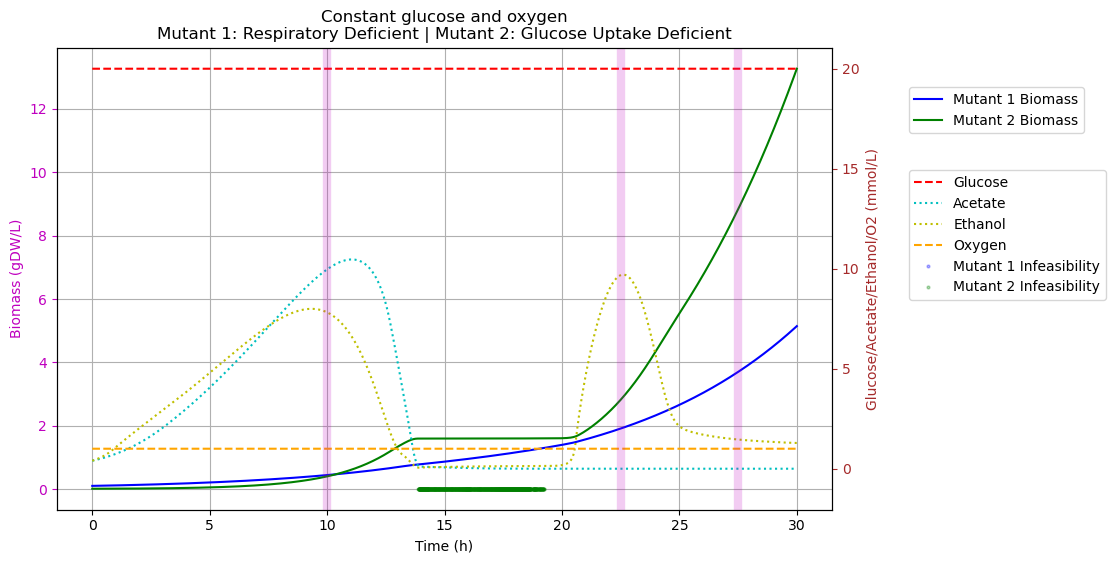

In [17]:
n_t = len(t_global)
t = np.array(t_global)

# select times where solutions are infeasible
infeasible_index_1 = sol_feasibility_global[0][:n_t] == 0
infeasible_index_2 = sol_feasibility_global[1][:n_t] == 0
t_inf_1 = t[infeasible_index_1]
t_inf_2 = t[infeasible_index_2]

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(t, mass_global[0][:n_t], label='Mutant 1 Biomass', color='b')
ax.plot(t, mass_global[1][:n_t], label='Mutant 2 Biomass', color='g')
ax.tick_params(axis='y', colors='m')
ax2 = plt.twinx(ax)
ax2.plot(t, metabolites_global[0][:n_t], color='r', label='Glucose', linestyle='--')
ax2.plot(t, metabolites_global[1][:n_t], color='c', label='Acetate', linestyle=':')
ax2.plot(t, metabolites_global[2][:n_t], color='y', label='Ethanol', linestyle=':')
ax2.plot(t, metabolites_global[3][:n_t], color='orange', label='Oxygen', linestyle='--')
ax2.tick_params(axis='y', colors='brown')

# plot on secondary y-axis the feasibility of both models
ax2.plot(t_inf_1, 0 * t_inf_1 - 0.50, 'bo', markersize=2, label=f'Mutant 1 Infeasibility', alpha=0.3)
ax2.plot(t_inf_2, 0 * t_inf_2 - 1.0, 'go', markersize=2, label=f'Mutant 2 Infeasibility', alpha=0.3)

ax.set_ylabel('Biomass (gDW/L)', color='m')
ax.set_xlabel('Time (h)', color='k')
ax2.set_ylabel('Glucose/Acetate/Ethanol/O2 (mmol/L)', color='brown')

# Add a vertical line in the plot at time points 10.00, 22.50 and 27.50
ax2.axvline(x=10.00, color='m', linestyle='-', linewidth=6, alpha=0.2)
ax2.axvline(x=22.50, color='m', linestyle='-', linewidth=6, alpha=0.2)
ax2.axvline(x=27.50, color='m', linestyle='-', linewidth=6, alpha=0.2)

ax.grid()

# Add a title in two lines. In the second line specifiy mutant 1 is respiratory deficient, and mutant 2 cannot uptake glucose
ax.title.set_text('Constant glucose and oxygen\nMutant 1: Respiratory Deficient | Mutant 2: Glucose Uptake Deficient')

# Place legends outside the figure frame on the top right
ax.legend(bbox_to_anchor=(1.09, 0.93), loc='upper left')
ax2.legend(bbox_to_anchor=(1.09, 0.75), loc='upper left')

plt.show()

### All fluxes at time points 10.0 *hrs*, 22.5 *hrs* and 27.5 *hrs* for both species

In [18]:
sol1_1000 = sol1_global[2000]
# sol1_1000
sol2_1000 = sol2_global[2000]
# sol2_1000

sol1_2250 = sol1_global[4500]
# sol1_2250
sol2_2250 = sol2_global[4500]
# sol2_2250

sol1_2750 = sol1_global[5500]
# sol1_2750
sol2_2750 = sol2_global[5500]
# sol2_2750

### Compare fluxes of the individual species at different time points

These fluxes are calculated before being updated for biomass and thus represent ***species-specific*** fluxes instead of ***community-wide*** (aka ***aggregated*** fluxes).

In [19]:
import pandas as pd

# Extract fluxes for sol1_1000, sol1_2250 and sol1_2750
data_1 = {
    'Glucose': [sol1_1000.fluxes['EX_glc__D_e'], sol1_2250.fluxes['EX_glc__D_e'], sol1_2750.fluxes['EX_glc__D_e']],
    'Acetate': [sol1_1000.fluxes['EX_ac_e'], sol1_2250.fluxes['EX_ac_e'], sol1_2750.fluxes['EX_ac_e']],
    'Ethanol': [sol1_1000.fluxes['EX_etoh_e'], sol1_2250.fluxes['EX_etoh_e'], sol1_2750.fluxes['EX_etoh_e']],
    'O2': [sol1_1000.fluxes['EX_o2_e'], sol1_2250.fluxes['EX_o2_e'], sol1_2750.fluxes['EX_o2_e']],
    'Biomass': [sol1_1000.fluxes['Biomass_Ecoli_core'], sol1_2250.fluxes['Biomass_Ecoli_core'], sol1_2750.fluxes['Biomass_Ecoli_core']]
}

df_flux_1 = pd.DataFrame(data_1, index=['10.0 hr', '22.5 hr', '27.5 hr'])
df_flux_1.index.name = "Mutant 1"
df_flux_1 = df_flux_1.round(3)
df_flux_1

,Glucose,Acetate,Ethanol,O2,Biomass
Mutant 1,,,,,
10.0 hr,-7.999,6.933,6.774,0.0,0.151
22.5 hr,-7.994,0.000,13.603,0.0,0.132
27.5 hr,-7.988,0.000,13.595,0.0,0.132


In [20]:

# Extract fluxes for sol2_1000, sol2_2250 and sol2_2750
data_2 = {
    'Glucose': [sol2_1000.fluxes['EX_glc__D_e'], sol2_2250.fluxes['EX_glc__D_e'], sol2_2750.fluxes['EX_glc__D_e']],
    'Acetate': [sol2_1000.fluxes['EX_ac_e'], sol2_2250.fluxes['EX_ac_e'], sol2_2750.fluxes['EX_ac_e']],
    'Ethanol': [sol2_1000.fluxes['EX_etoh_e'], sol2_2250.fluxes['EX_etoh_e'], sol2_2750.fluxes['EX_etoh_e']],
    'O2': [sol2_1000.fluxes['EX_o2_e'], sol2_2250.fluxes['EX_o2_e'], sol2_2750.fluxes['EX_o2_e']],
    'Biomass': [sol2_1000.fluxes['Biomass_Ecoli_core'], sol2_2250.fluxes['Biomass_Ecoli_core'], sol2_2750.fluxes['Biomass_Ecoli_core']]
}

df_flux_2 = pd.DataFrame(data_2, index=['10.0 hr', '22.5 hr', '27.5 hr'])
df_flux_2.index.name = "Mutant 2"
df_flux_2 = df_flux_2.round(3)
df_flux_2

,Glucose,Acetate,Ethanol,O2,Biomass
Mutant 2,,,,,
10.0 hr,0.0,-5.578,-8.864,-19.794,0.411
22.5 hr,0.0,-0.000,-9.052,-14.242,0.295
27.5 hr,0.0,-0.000,-5.471,-9.278,0.163


### Display Escher maps of the fluxes for both species at different time points

In [21]:
import escher
from escher import Builder


### 10 hrs

In [22]:

builder_mutant_1_10hrs = Builder(height=1200, width=1200)
builder_mutant_1_10hrs.model = model1
builder_mutant_1_10hrs.map_json = 'E_coli_core.map.json'
builder_mutant_1_10hrs.full_screen_button = False
builder_mutant_1_10hrs.reaction_data = sol1_1000.fluxes

builder_mutant_2_10hrs = Builder(height=1200, width=1200)
builder_mutant_2_10hrs.model = model2
builder_mutant_2_10hrs.map_json = 'E_coli_core.map.json'
builder_mutant_2_10hrs.full_screen_button = False
builder_mutant_2_10hrs.reaction_data = sol2_1000.fluxes


### Mutant 1 (10 hrs)

In [23]:
builder_mutant_1_10hrs

Builder(full_screen_button=False, height=1200, reaction_data={'ACALD': -6.773579556832058, 'ACALDt': 0.0, 'ACK…

### Mutant 2 (10 hrs)

In [24]:
builder_mutant_2_10hrs

Builder(full_screen_button=False, height=1200, reaction_data={'ACALD': 8.864139528264012, 'ACALDt': 0.0, 'ACKr…

### 27.5 hrs

In [25]:

builder_mutant_1_275hrs = Builder(height=1200, width=1200)
builder_mutant_1_275hrs.model = model1
builder_mutant_1_275hrs.map_json = 'E_coli_core.map.json'
builder_mutant_1_275hrs.full_screen_button = False
builder_mutant_1_275hrs.reaction_data = sol1_2750.fluxes

builder_mutant_2_275hrs = Builder(height=1200, width=1200)
builder_mutant_2_275hrs.model = model2
builder_mutant_2_275hrs.map_json = 'E_coli_core.map.json'
builder_mutant_2_275hrs.full_screen_button = False
builder_mutant_2_275hrs.reaction_data = sol2_2750.fluxes


### Mutant 1 (27.5 hrs)

In [26]:
builder_mutant_1_275hrs

Builder(full_screen_button=False, height=1200, reaction_data={'ACALD': -13.594806295664041, 'ACALDt': 0.0, 'AC…

### Mutant 2 (27.5 hrs)

In [27]:
builder_mutant_2_275hrs

Builder(full_screen_button=False, height=1200, reaction_data={'ACALD': 5.471125908245515, 'ACALDt': 0.0, 'ACKr…